https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints

Task 1:

This task is to write an executable code that takes the input scene and the text prompt from the command line argument and outputs an image with a red mask on all pixels where the object (denoted in the text prompt) was present.

(e.g. python run.py--image ./example.jpg--class "chair"--output ./generated.png)

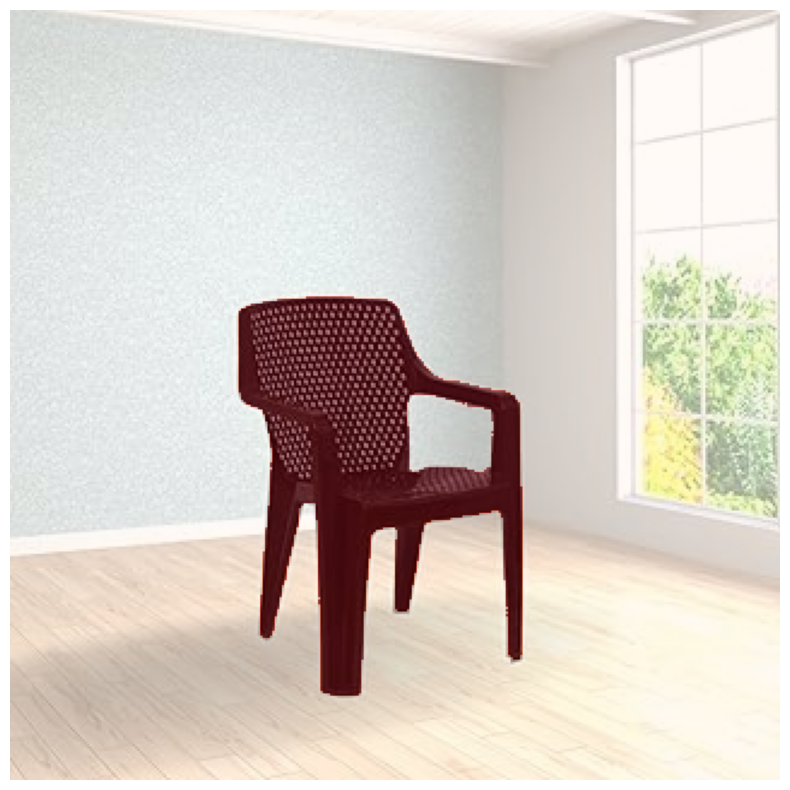

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Load CLIP model from HuggingFace
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load SAM model (segment-anything)
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

def get_clip_text_image_similarity(image, text_prompt):
    inputs = clip_processor(text=text_prompt, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    return logits_per_image.item()

def segment_image_with_sam(image, region):
    predictor.set_image(image)
    masks, _, _ = predictor.predict(point_coords=region, point_labels=np.array([1]))
    return masks

def run_segmentation(image_path, text_prompt, output_path):
    # Preprocess image and run CLIP
    image_rgb = preprocess_image(image_path)
    similarity_score = get_clip_text_image_similarity(image_rgb, text_prompt)
    
    # Assuming a specific region has high similarity (for simplicity, using whole image for now)
    height, width, _ = image_rgb.shape
    region = np.array([[width//2, height//2]])
    
    # Segment using SAM
    mask = segment_image_with_sam(image_rgb, region)

    # Visualize and save the result
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.imshow(mask[0], alpha=0.5, cmap='Reds')  # Display the red mask
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()

# Run the task
run_segmentation('pose_editing_examples/chair.jpg', 'chair', 'generated_chair.png')

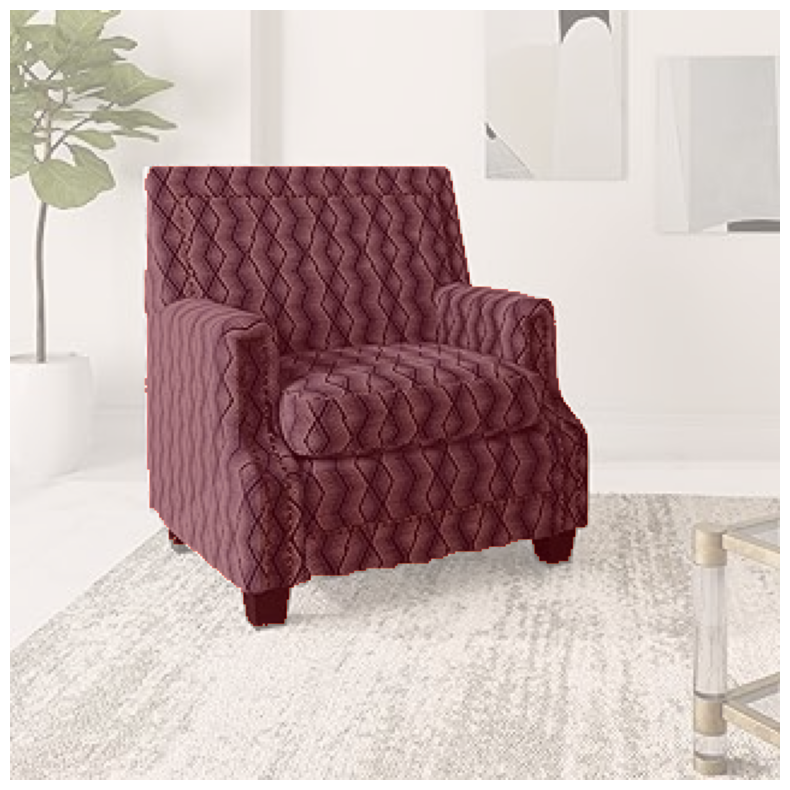

In [7]:
run_segmentation('pose_editing_examples/sofa.jpg', 'sofa', 'generated_sofa.png')

Task 2:

The second task is to change the pose of the segmented object by the relative angles given by the user. You can use a consistent direction as positive azimuth and polar angle change and mention what you used.
(e.g. python run.py--image ./example.jpg--class "chair"--azimuth +72--polar +0--output ./generated.png)
 
The generated image:
- Should preserve the scene (background)
- Should adhere to the relative angles given by the user

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
import cv2
import numpy as np
from segment_anything import SamPredictor, sam_model_registry
from edsr import EDSRModel

# Load CLIP and SAM models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)

# Preprocess image for CLIP and SAM
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

# Run CLIP to get similarity score
def run_clip(image, text_prompt):
    inputs = clip_processor(text=text_prompt, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    return outputs.logits_per_image.item()

# Use SAM to generate the mask
def run_sam(image, region):
    predictor.set_image(image)
    masks, _, _ = predictor.predict(point_coords=region, point_labels=np.array([1]))
    return masks

# Highlight object by making non-object pixels white
def highlight_object(image, mask):
    highlighted_image = image.copy()
    highlighted_image[mask == 0] = [255, 255, 255]  # Set non-object pixels to white
    return highlighted_image

# Run Zero123 to perform pose editing
def run_zero123(image_path, azimuth, polar, output_path):
    # Assuming you have already set up the Zero123 repo
    command = f"python zero123/inference.py --image {image_path} --azimuth {azimuth} --polar {polar} --output {output_path}"
    os.system(command)

# Use EDSR to enhance the object size
def enhance_object_with_edsr(image_path, output_path):
    edsr_model = EDSRModel.from_pretrained("eugenesiow/edsr-base")
    image = cv2.imread(image_path)
    enhanced_image = edsr_model.enhance(image)
    cv2.imwrite(output_path, enhanced_image)
    return enhanced_image

# Apply alpha channel to make the background transparent
def apply_alpha(image, mask):
    image_alpha = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    image_alpha[:, :, 3] = mask * 255
    return image_alpha

# Pad the binary mask using dilation
def pad_mask(mask, kernel_size=50):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    return dilated_mask

# Use SD inpainting to extract the background
def run_sd_inpainting(image_path, mask_path, output_path):
    command = f"python sd_inpainting.py --input {image_path} --mask {mask_path} --output {output_path}"
    os.system(command)

# Composite the rotated object back into the scene
def composite_images(background, object_image, mask):
    # Overlay the rotated object on the background
    background[mask != 0] = object_image[mask != 0]
    return background



# Main function
def run_pose_editing_pipeline(image_path, text_prompt, azimuth, polar, output_path):
    # Preprocess and run CLIP + SAM to get the mask
    image_rgb = preprocess_image(image_path)
    clip_score = run_clip(image_rgb, text_prompt)
    region = np.array([[image_rgb.shape[1] // 2, image_rgb.shape[0] // 2]])  # Placeholder region
    mask = run_sam(image_rgb, region)

    # Highlight the object
    highlighted_image = highlight_object(image_rgb, mask[0])
    cv2.imwrite("highlighted_image.png", highlighted_image)

    # Run Zero123 to edit the object's pose
    run_zero123("highlighted_image.png", azimuth, polar, "object_3D.png")

    # Enhance the object with EDSR and apply alpha channel
    enhanced_image = enhance_object_with_edsr("object_3D.png", "enhanced_object.png")
    mask_enhanced = run_sam(enhanced_image, region)  # Run SAM on enhanced object
    enhanced_alpha_object = apply_alpha(enhanced_image, mask_enhanced[0])
    cv2.imwrite("enhanced_alpha_object.png", enhanced_alpha_object)

    # Pad the mask and inpaint the background
    dilated_mask = pad_mask(mask[0])
    cv2.imwrite("dilated_mask.png", dilated_mask)
    run_sd_inpainting(image_path, "dilated_mask.png", "background_inpainted.png")

    # Composite the object back into the original scene
    background_inpainted = cv2.imread("background_inpainted.png")
    final_composite = composite_images(background_inpainted, enhanced_alpha_object, mask_enhanced[0])
    cv2.imwrite(output_path, final_composite)

# Example
run_pose_editing_pipeline("input.jpg", "chair", 72, 0, "final_composite.png")
